# Simulated charge stability diagrams for a 2x2 quantum dot system

This example shows how to use `qtt.simulation.dotsystem` to define a Hubbard-based model system of a 4 quantum dot array in a 2x2 plaquette configuration. Here we will use this model system to reproduce the Fig 1c plot from https://aip.scitation.org/doi/10.1063/1.5025928 

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import qtt.simulation.dotsystem as dotsystem

Define some extra helper functions:

In [2]:
def gates_from_det(dot_system, det_values=None):
    """ Sets the correct gate voltages. Run this function after setting the detuning variables."""
    if det_values:
        return np.dot(np.linalg.inv(dot_system.la_matrix), det_values)
    det_values = [getattr(dot_system, 'det%d' % (i + 1)) for i in range(dot_system.ndots)]
    gate_values = np.dot(np.linalg.inv(dot_system.la_matrix), det_values)
    for i in range(dot_system.ndots):
        setattr(dot_system, 'P%d' % (i + 1), gate_values[i])
    return gate_values


def det_from_gates(dot_system, plunger_values=None):
    """ Sets the correct detuning variables that matches the gate combination.
        Run this function after setting the gate voltages.
    """
    if plunger_values:
        return np.dot(dot_system.la_matrix, plunger_values)
    plunger_values = np.array([getattr(dot_system, 'P%d' % (i + 1)) for i in range(dot_system.ndots)])
    det_values = np.dot(dot_system.la_matrix, plunger_values)
    for i in range(dot_system.ndots):
        setattr(dot_system, 'det%d' % (i + 1), det_values[i])
    return det_values


def parse_scan_parameters(dot_system, scan_parameters, scan_steps, scan_range):
    """ Used to parse the input to the simulate_honeycomb function."""
    half_range = scan_range/2
    scan_steps_x, scan_steps_y = scan_steps
    scan_min_max = [[-half_range, half_range, -half_range, half_range],
               [-half_range, -half_range, half_range, half_range]]
    dot_system.makeparamvalues2D(scan_parameters, scan_min_max, scan_steps_x, scan_steps_y)
    
    if scan_parameters[0].startswith('det'):
        for parameter in dot_system.scan_parameters:
            dot_system.vals2D[pn] += getattr(dot_system, parameter)
            parameters = dot_system.vals2D.copy()
        return parameters

    initial_values = dot_system.getall('det')
    det = [np.zeros(dot_system.vals2D[scan_parameters[0]].shape) for i in range (dot_system.ndots)]
    params = dot_system.vals2D.copy()
    dict_params = {}
    for name in scan_parameters:
        if '{' in name:
            dict_prop = eval(name)
            for name2, prop in dict_prop.items():
                dict_params[name2] = getattr(dot_system, name2) + params[name] * prop
        else: 
            dict_params[name] = getattr(dot_system, name) + params[name]        
    for step_x in range(scan_steps_x):
        for step_y in range(scan_steps_y):
            for pn, pv in dict_params.items():
                setattr(dot_system, pn, pv[step_x, step_y])
            det_temp = det_from_gates(dot_system)
            for k in range(len(det_temp)):
                det[k][step_x, step_y] = det_temp[k]

    dot_system.setall('det', initial_values)

    dot_system.vals2D = {}
    for i in range(len(det)):
        dot_system.vals2D['det%i' % (i + 1)] = det[i]
    
    return params


def show_charge_occupation_numbers_on_click(dot_system, x_data, y_data, number_of_clicks=1):
    """ Shows the charge occupation numbers at the clicked points in the plotted charge stability diagram.
    
    Args:
        dot_system (dot_system): The simulated dot system.
        x_data (np.array): The parsed result data from the independent gate variable.
        y_data (np.array): The parsed result data from the dependent gate variable.
        number_of_clicks (int): The number of times the occupation numbers should be printed.
    """
    mV_minimum_x = x_data.min()
    mV_minimum_y = y_data.min()
    mV_range_x = x_data.max() - mV_minimum_x
    mV_range_y = y_data.max() - mV_minimum_y
    pixels_range_x, pixels_range_y = np.shape(x_data)
    
    for i in range(number_of_clicks):
        mouse_clicks = plt.ginput()
        if mouse_clicks:
            (mV_coordinate_x, mV_coordinate_y) = mouse_clicks[0]
            
            x_index = int((mV_coordinate_x - mV_minimum_x) / mV_range_x * pixels_range_x)
            y_index = int((mV_coordinate_y - mV_minimum_y) / mV_range_y * pixels_range_y)
            
            charge_occupation_numbers = str(dot_system.hcgs[y_index, x_index])
            plt.text(mV_coordinate_x, mV_coordinate_y, charge_occupation_numbers, color='white')

## Initialize the model system with the experimental parameters

In [3]:
def initialize_two_by_two_system():
    """ Creates the two by two quantum model. The parameters are set according to the experimental setup."""
    two_by_two = dotsystem.TwoXTwo()

    # cross-capacitance matrix and lever arms
    #                                     P1      P2     P3     P4
    cross_capacitance_matrix = np.array([[ 1.00,  0.45,  0.54,  0.87],  # Dot 1
                                         [ 0.65,  1.00,  0.47,  0.50],  # Dot 2
                                         [ 0.17,  0.47,  1.00,  0.24],  # Dot 3
                                         [ 0.44,  0.35,  0.88,  1.00]]) # Dot 4

    det_to_plunger = np.array([0.039 * np.ones(4), 0.041 * np.ones(4),
                               0.054 * np.ones(4), 0.031 * np.ones(4)]) # meV/mV

    two_by_two.la_matrix = cross_capacitance_matrix * det_to_plunger

    # All the following values in meV
    # On-site interaction per dot
    two_by_two.osC1 = 2.5
    two_by_two.osC2 = 2.3
    two_by_two.osC3 = 3
    two_by_two.osC4 = 1.8

    # Intersite interaction per pairs of dots
    two_by_two.isC1 = 0.47 # 1-2
    two_by_two.isC2 = 0.35 # 2-3
    two_by_two.isC3 = 0.43 # 3-4
    two_by_two.isC4 = 0.30 # 4-1
    two_by_two.isC5 = 0.28 # 1-3
    two_by_two.isC6 = 0.18 # 2-4

    # Tunnel coupling per pairs of dots
    two_by_two.tun1 = 0.02 # 1-2
    two_by_two.tun2 = 0.02 # 2-3
    two_by_two.tun3 = 0.02 # 3-4
    two_by_two.tun4 = 0.02 # 4-1

    # Energy offsets per dot (0 is the boundary for adding 1 electron)
    two_by_two.det1 = 1
    two_by_two.det2 = 1
    two_by_two.det3 = 0
    two_by_two.det4 = 0

    gate_voltages = gates_from_det(two_by_two) # This adds the gate voltages (tbt.P#, in mV) that result in the above detuning
    print('Current gate voltages: P1={:.2f} mV, P2={:.2f} mV, P3={:.2f} mV, P4={:.2f} mV'.format(*gate_voltages))
    return two_by_two

## Run a 2D gate scan simulation and plot the charge stability diagram

Current gate voltages: P1=35.83 mV, P2=11.19 mV, P3=-8.40 mV, P4=-12.29 mV
simulatehoneycomb: 15.45 [s]


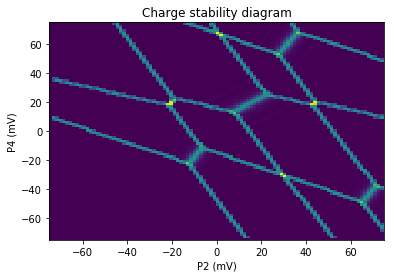

In [4]:
two_by_two = initialize_two_by_two_system()

scan_parameters = ['P2', 'P4']
parameter_x, parameter_y = scan_parameters
scan_steps = [61, 61]
scan_range = 150

parsed_results = parse_scan_parameters(two_by_two, scan_parameters, scan_steps, scan_range)
two_by_two.simulatehoneycomb()

x_values = parsed_results[parameter_x]
y_values = parsed_results[parameter_y]

plt.figure()
plt.pcolor(x_values, y_values, two_by_two.honeycomb)
plt.xlabel("{0} (mV)".format(parameter_x))
plt.ylabel("{0} (mV)".format(parameter_y))
_ = plt.title('Charge stability diagram')

If you would like to check the charge occupation states at different points in the charge stability diagram, you can do that using the method below. The module matplotlib is set to interactive mode using `%pylab tk`. This will show up a new window that allows for clicking functionality. 

Populating the interactive namespace from numpy and matplotlib
Current gate voltages: P1=35.83 mV, P2=11.19 mV, P3=-8.40 mV, P4=-12.29 mV
simulatehoneycomb: 15.45 [s]


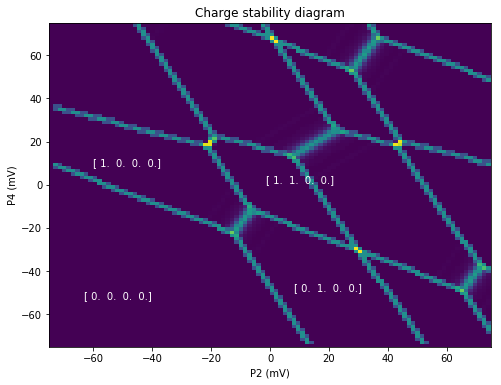

In [5]:
%pylab tk

two_by_two = initialize_two_by_two_system()

scan_parameters = ['P2', 'P4']
parameter_x, parameter_y = scan_parameters
scan_steps = [61, 61]
scan_range = 150

parsed_results = parse_scan_parameters(two_by_two, scan_parameters, scan_steps, scan_range)
two_by_two.simulatehoneycomb()

x_values = parsed_results[parameter_x]
y_values = parsed_results[parameter_y]

plt.figure()
plt.pcolor(x_values, y_values, two_by_two.honeycomb)
plt.xlabel("{0} (mV)".format(parameter_x))
plt.ylabel("{0} (mV)".format(parameter_y))
_ = plt.title('Charge stability diagram')

show_charge_occupation_numbers_on_click(two_by_two, x_values, y_values, number_of_clicks=4)